In [7]:
import os
import torch
from torchvision import transforms
from torch import nn
from helper_utils import set_deterministic, set_all_seeds
from helper_data import get_dataloaders_mnist
from helper_train import train_autoencoder_v1
from helper_plotting import plot_training_loss, plot_generated_images
from helper_evaluate import compute_epoch_loss_autoencoder

In [12]:
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 20

Device: cuda:0


In [15]:
train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    num_workers=2,
    validation_fraction=0.)

In [16]:
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([2, 9, 3, 2, 1, 7, 2, 8, 2, 7])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


In [17]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(3136, 2)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
model = AutoEncoder()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
log_dict = train_autoencoder_v1(num_epochs=NUM_EPOCHS, model=model,
                                optimizer=optimizer, device=DEVICE,
                                train_loader=train_loader,
                                skip_epoch_stats=True,
                                logging_interval=250)

Epoch: 001/020 | Batch 0000/1875 | Loss: 0.2330
Epoch: 001/020 | Batch 0250/1875 | Loss: 0.0560
Epoch: 001/020 | Batch 0500/1875 | Loss: 0.0486
Epoch: 001/020 | Batch 0750/1875 | Loss: 0.0512
Epoch: 001/020 | Batch 1000/1875 | Loss: 0.0513
Epoch: 001/020 | Batch 1250/1875 | Loss: 0.0542
Epoch: 001/020 | Batch 1500/1875 | Loss: 0.0476
Epoch: 001/020 | Batch 1750/1875 | Loss: 0.0485
Time elapsed: 0.31 min
Epoch: 002/020 | Batch 0000/1875 | Loss: 0.0526
Epoch: 002/020 | Batch 0250/1875 | Loss: 0.0414
Epoch: 002/020 | Batch 0500/1875 | Loss: 0.0446
Epoch: 002/020 | Batch 0750/1875 | Loss: 0.0476
Epoch: 002/020 | Batch 1000/1875 | Loss: 0.0467
Epoch: 002/020 | Batch 1250/1875 | Loss: 0.0475
Epoch: 002/020 | Batch 1500/1875 | Loss: 0.0401
Epoch: 002/020 | Batch 1750/1875 | Loss: 0.0466
Time elapsed: 0.63 min
Epoch: 003/020 | Batch 0000/1875 | Loss: 0.0426
Epoch: 003/020 | Batch 0250/1875 | Loss: 0.0473
Epoch: 003/020 | Batch 0500/1875 | Loss: 0.0452
Epoch: 003/020 | Batch 0750/1875 | Loss: 0

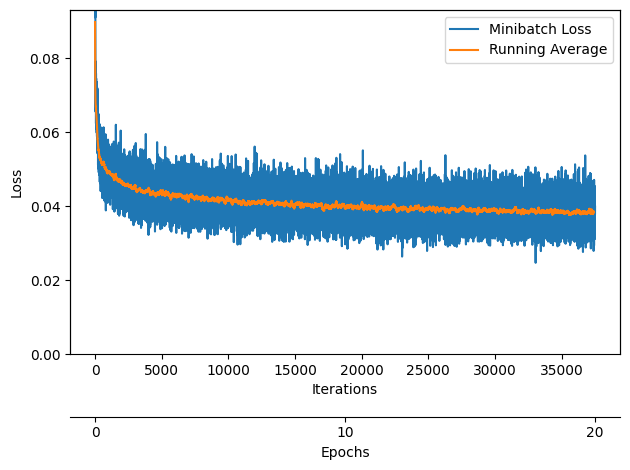

In [20]:
import matplotlib.pyplot as plt
plot_training_loss(log_dict['train_loss_per_batch'], NUM_EPOCHS)
plt.show()

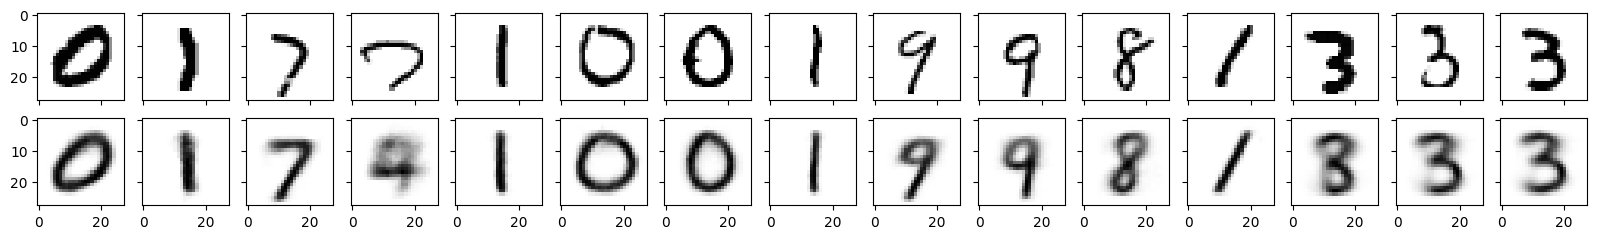

In [21]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE)


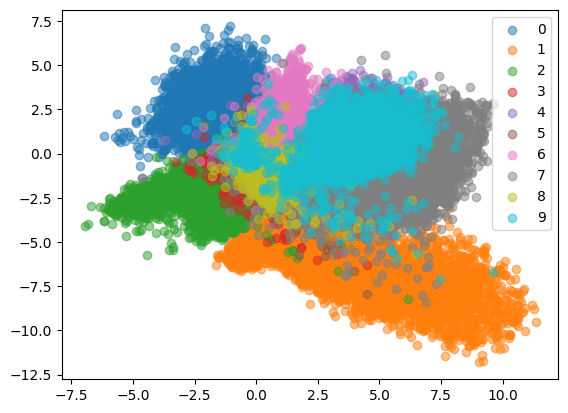

In [25]:
from helper_plotting import plot_latent_space_with_labels
NUM_CLASSES = 10

plot_latent_space_with_labels(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    model=model,
    device=DEVICE)

plt.legend()
plt.show()

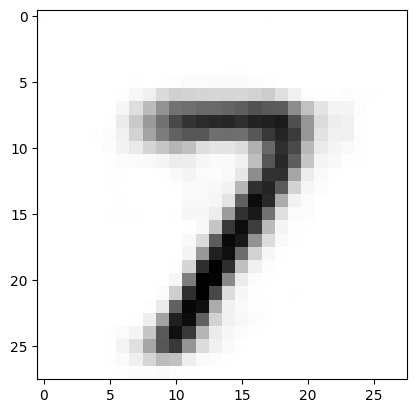

In [26]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([2.5, -2.5]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

## Part-2